In [1]:
pip install yfinance pandas tensorflow scikit-learn matplotlib

In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, Dense, Input, Flatten
from tensorflow.keras.layers import TimeDistributed, Conv1D, Activation
from tensorflow.keras.layers import LayerNormalization, Add
from tensorflow.keras.layers import Lambda
import os

sensex_tickers = ["RELIANCE.NS", "TCS.NS", "HDFCBANK.NS", "INFY.NS"]

start_date = input("Enter start date (YYYY-MM-DD): ")
end_date = input("Enter end date (YYYY-MM-DD): ")

def download_data(ticker):
    print(f'Downloading data for {ticker}')
    data = yf.download(ticker, start=start_date, end=end_date)
    if not data.empty:
        filename = f"{ticker.replace('.NS', '')}_data.csv"
        data.to_csv(filename)
        print(f'Data saved to {filename}')
        return data
    else:
        print(f'No data available for {ticker}')
        return None

# Download data for all tickers
stock_data = {}
for ticker in sensex_tickers:
    data = download_data(ticker)
    if data is not None:
        stock_data[ticker] = data


Enter start date (YYYY-MM-DD): 2022-01-01
Enter end date (YYYY-MM-DD): 2023-12-12


[*********************100%***********************]  1 of 1 completed


Data saved to RELIANCE_data.csv


[*********************100%***********************]  1 of 1 completed


Data saved to TCS_data.csv


[*********************100%***********************]  1 of 1 completed


Data saved to HDFCBANK_data.csv


[*********************100%***********************]  1 of 1 completed

Data saved to INFY_data.csv


In [3]:
data

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,INFY.NS,INFY.NS,INFY.NS,INFY.NS,INFY.NS,INFY.NS
Date,,,,,,
2022-01-03 00:00:00+00:00,1764.716187,1898.449951,1914.050049,1887.750000,1887.750000,3329616
2022-01-04 00:00:00+00:00,1765.367065,1899.150024,1906.650024,1878.000000,1898.449951,3921999
2022-01-05 00:00:00+00:00,1714.706177,1844.650024,1902.900024,1840.000000,1900.000000,6995719
2022-01-06 00:00:00+00:00,1689.747681,1817.800049,1828.000000,1800.000000,1828.000000,6449205
2022-01-07 00:00:00+00:00,1686.494141,1814.300049,1836.000000,1806.800049,1815.449951,4834389
...,...,...,...,...,...,...
2023-12-05 00:00:00+00:00,1417.439453,1453.949951,1466.900024,1442.000000,1465.800049,5123039
2023-12-06 00:00:00+00:00,1437.278564,1474.300049,1477.000000,1451.050049,1456.750000,5269178


In [4]:
def preprocess_data(data, look_back=60):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data[['Close']])

    X, y = [], []
    for i in range(look_back, len(scaled_data)):
        X.append(scaled_data[i-look_back:i, 0])
        y.append(scaled_data[i, 0])

    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    return X, y, scaler

# Preprocess all stocks data
preprocessed_data = {}
for ticker, data in stock_data.items():
    X, y, scaler = preprocess_data(data)
    preprocessed_data[ticker] = (X, y, scaler)


In [5]:
def residual_block(x, dilation_rate):
    previous_block_activation = x  # residual connection

    x = LayerNormalization()(x)
    x = Conv1D(64, 3, padding="causal", dilation_rate=dilation_rate)(x)
    x = Activation("relu")(x)

    x = Conv1D(64, 3, padding="causal", dilation_rate=dilation_rate)(x)
    x = Add()([x, previous_block_activation])
    return x

def build_hybrid_model(input_shape):
    inputs = Input(shape=input_shape)

    # CNN layers
    x = Conv1D(filters=64, kernel_size=3, activation='relu')(inputs)
    x = Conv1D(filters=64, kernel_size=3, activation='relu')(x)

    # TCN layers
    x = residual_block(x, 1)
    x = residual_block(x, 2)
    x = residual_block(x, 4)

    x = Flatten()(x)
    outputs = Dense(1)(x)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Build the model
model = build_hybrid_model((60, 1))
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 60, 1)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 58, 64)         │            256 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 56, 64)         │         12,352 │ conv1d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 56, 64)         │            128 │ conv1d_1[0][0]         │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, 56, 64)         │         12,352 │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 56, 64)         │              0 │ conv1d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_3 (Conv1D)         │ (None, 56, 64)         │         12,352 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 56, 64)         │              0 │ conv1d_3[0][0],        │
│                           │                        │                │ conv1d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 56, 64)         │            128 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_4 (Conv1D)         │ (None, 56, 64)         │         12,352 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 56, 64)         │              0 │ conv1d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_5 (Conv1D)         │ (None, 56, 64)         │         12,352 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 56, 64)         │              0 │ conv1d_5[0][0],        │
│                           │                        │                │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 56, 64)         │            128 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_6 (Conv1D)         │ (None, 56, 64)         │         12,352 │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 56, 64)         │              0 │ conv1d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_7 (Conv1D)         │ (None, 56, 64)         │         12,352 │ activation_2[0][0]     │
├──────────────────────

 Total params: 90,689 (354.25 KB)

 Trainable params: 90,689 (354.25 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
def train_and_predict(ticker, X, y, scaler, epochs=20, batch_size=32):
    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the model
    model = build_hybrid_model(X_train.shape[1:])
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

    # Make predictions
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)

    actual = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Save predictions and actual data to CSV
    result_df = pd.DataFrame({'Actual': actual.flatten(), 'Predicted': predictions.flatten()})
    result_filename = f"{ticker.replace('.NS', '')}_predictions.csv"
    result_df.to_csv(result_filename, index=False)
    print(f'Predictions saved to {result_filename}')

    return result_df

# Train and predict for all tickers
results = {}
for ticker, (X, y, scaler) in preprocessed_data.items():
    results[ticker] = train_and_predict(ticker, X, y, scaler)


Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step - loss: 10.8773
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - loss: 0.8586
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - loss: 0.3455
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - loss: 0.1459
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - loss: 0.0699
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0365
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0250
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0291
Epoch 9/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0215
Epoch 10/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0213
Epoch 11/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0184
Epoch 12/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0170
Epoch 13/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0176
Epoch 14/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0154
Epoch 15/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.014

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step
Predictions saved to HDFCBANK_predictions.csv
Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 7.0837
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.6197
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.1654
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0592
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0238
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0149
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0127
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0111
Epoch 9/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0103
Epoch 10/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0098
Epoch 11/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0079
Epoch 12/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0085
Epoch 13/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0086
Epoch 14/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step -

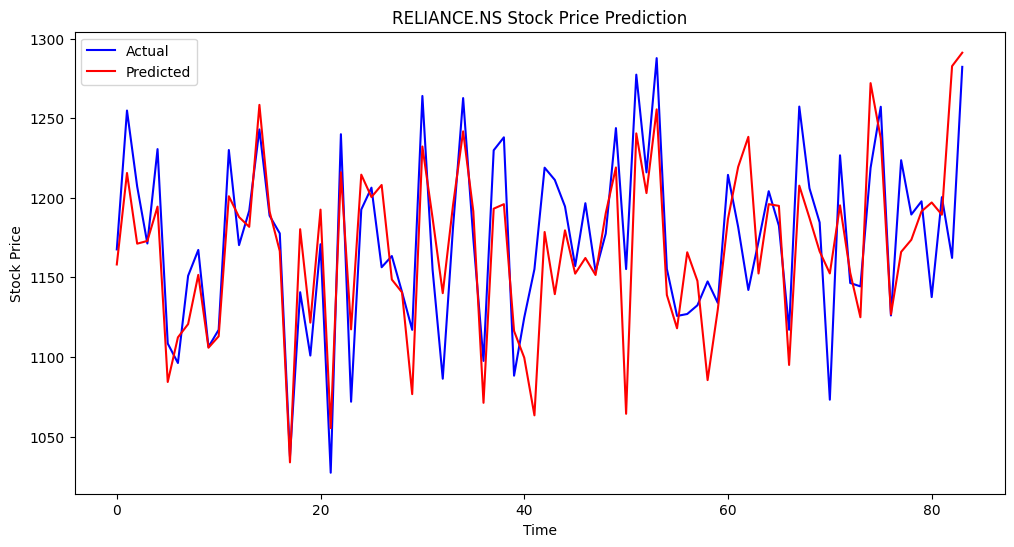

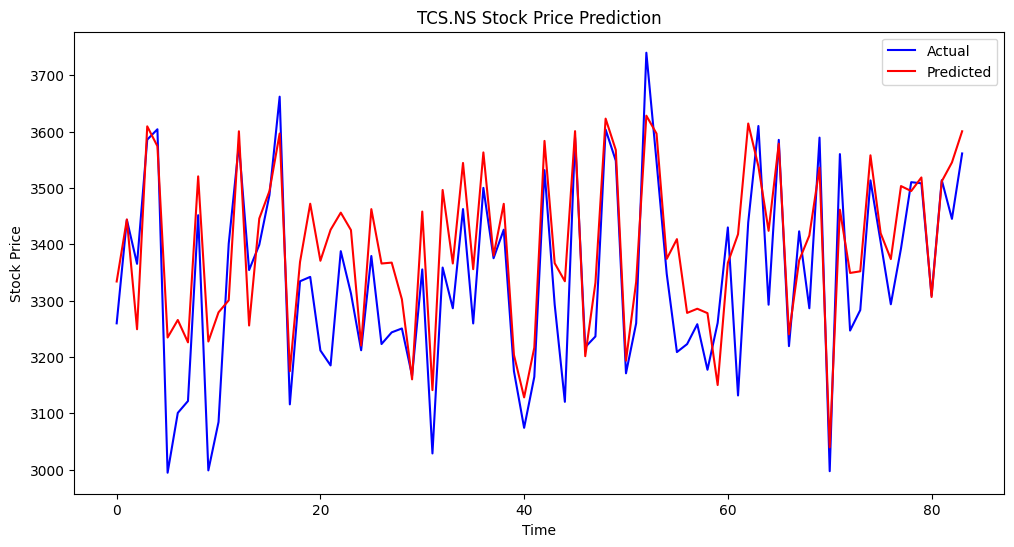

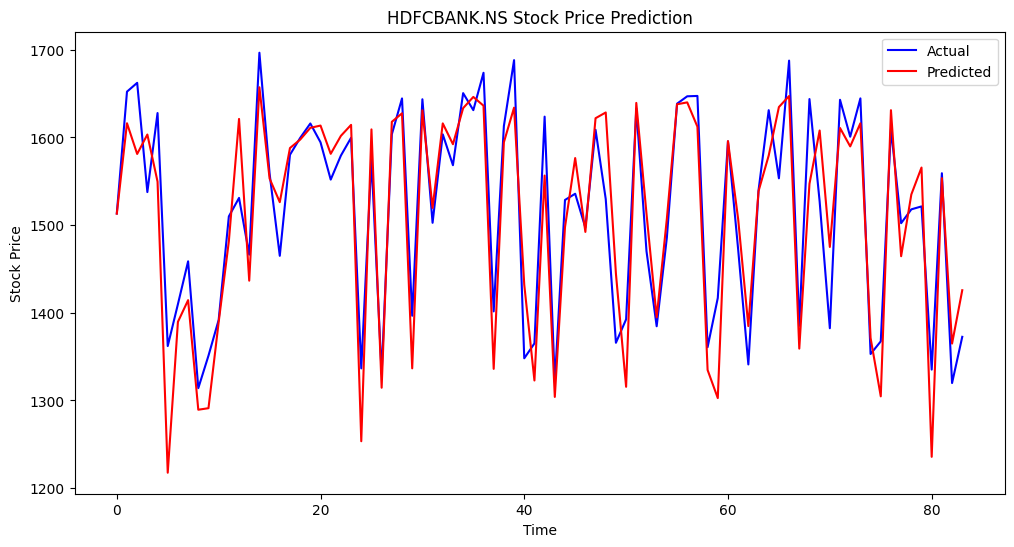

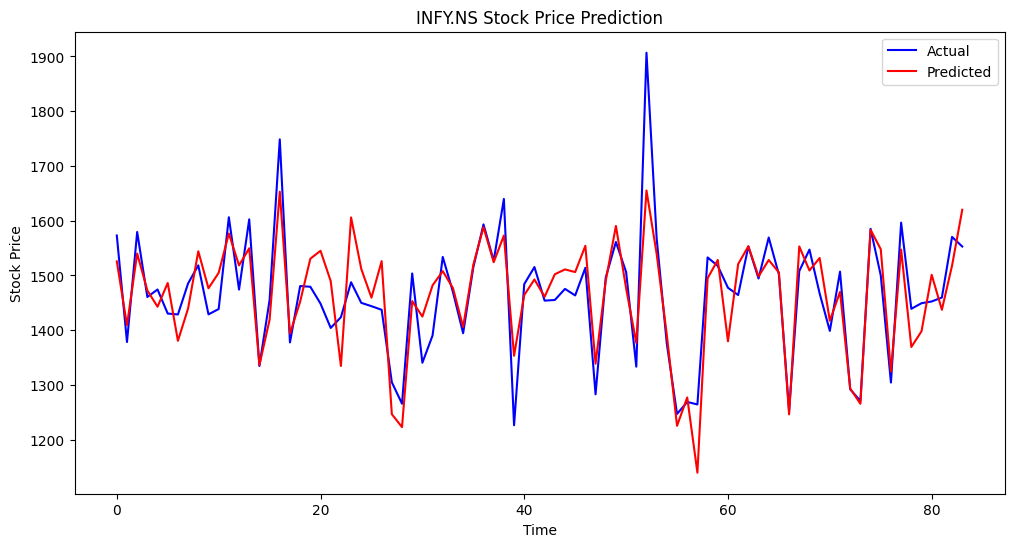

In [7]:
def plot_predictions(ticker, result_df):
    plt.figure(figsize=(12, 6))
    plt.plot(result_df['Actual'], color='blue', label='Actual')
    plt.plot(result_df['Predicted'], color='red', label='Predicted')
    plt.title(f"{ticker} Stock Price Prediction")
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

# Plot predictions for all tickers
for ticker, result_df in results.items():
    plot_predictions(ticker, result_df)


In [8]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_predictions(ticker, result_df):
    # Calculate MAE, MSE, RMSE, and R²
    mae = mean_absolute_error(result_df['Actual'], result_df['Predicted'])
    mse = mean_squared_error(result_df['Actual'], result_df['Predicted'])
    rmse = np.sqrt(mse)
    r2 = r2_score(result_df['Actual'], result_df['Predicted'])

    # Calculate Directional Accuracy
    actual_direction = np.sign(result_df['Actual'].diff().dropna())
    predicted_direction = np.sign(result_df['Predicted'].diff().dropna())
    directional_accuracy = (actual_direction == predicted_direction).mean() * 100

    # Print metrics
    print(f"Metrics for {ticker}:")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"R² Score: {r2}")
    print(f"Directional Accuracy: {directional_accuracy}%")

    # Return metrics as a dictionary for further use if needed
    return {
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R2": r2,
        "Directional Accuracy": directional_accuracy
    }

# Evaluate predictions for all tickers
metrics = {}
for ticker, result_df in results.items():
    metrics[ticker] = evaluate_predictions(ticker, result_df)

Metrics for RELIANCE.NS:
Mean Absolute Error (MAE): 28.113596598307296
Mean Squared Error (MSE): 1340.318598833645
Root Mean Squared Error (RMSE): 36.61036190525361
R² Score: 0.5590749789171954
Directional Accuracy: 75.90361445783132%
Metrics for TCS.NS:
Mean Absolute Error (MAE): 79.3567359561012
Mean Squared Error (MSE): 10182.22885555029
Root Mean Squared Error (RMSE): 100.90703075380966
R² Score: 0.6518842308902413
Directional Accuracy: 84.33734939759037%
Metrics for HDFCBANK.NS:
Mean Absolute Error (MAE): 38.743560791015625
Mean Squared Error (MSE): 2454.2879201413266
Root Mean Squared Error (RMSE): 49.54077028207501
R² Score: 0.8106880127798478
Directional Accuracy: 83.13253012048193%
Metrics for INFY.NS:
Mean Absolute Error (MAE): 43.68226405552454
Mean Squared Error (MSE): 3323.1427734013455
Root Mean Squared Error (RMSE): 57.646706526924376
R² Score: 0.7323764802255525
Directional Accuracy: 85.54216867469879%
